In [1]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [2]:
df =pd.read_pickle('../pickle_pd/second_pd_top_25.pkl')
features = list(df)[:-1]
y = df.pop('label')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = tf.keras.utils.to_categorical(y_encoded)

In [3]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], y_one_hot, test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [9]:
space={#'dimension': hp.uniform("dimension", 64, 256),
        'learning_rate': hp.uniform ('learning_rate', 0.0005,0.005),
        'beta_1' : hp.uniform('beta_1', 0.5,0.99),
        'beta_2' : hp.uniform('beta_2', 0.8,0.9999),
        'epsilon' : hp.uniform('epsilon', 1e-08,1e-06),
        'ema_momentum' : hp.uniform('ema_momentum', 0.8, 0.999),
        'dropout' : hp.uniform('dropout', 0,0.5),
        'size_l_1' : hp.choice('size_l_1',[64, 128, 256]),
        'size_l_2' : hp.choice('size_l_2',[32, 64, 128]),
        'size_l_3' : hp.choice('size_l_3',[16, 32, 64]),
        'extra_lay': hp.choice('extra_lay',[0, 1 ,2])
        
    }

In [19]:
def objective(space):
    optimizer = Adam(learning_rate=space['learning_rate'],
                     beta_1=space['beta_1'], beta_2=space['beta_2'],
                     epsilon=space['epsilon'],
                     ema_momentum=space['ema_momentum'])
                
    model = Sequential()
    
    model.add(Dense(space['size_l_1'], activation='relu', input_dim=25))
    model.add(Dropout(space['dropout']))
    model.add(Dense(space['size_l_2'], activation='relu'))
    model.add(Dense(space['size_l_3'], activation='relu'))
    
    if space['extra_lay'] == 1:
        model.add(Dense(16, activation='relu'))
    elif space['extra_lay'] == 2:
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
    
    model.add(Dense(3, activation='softmax'))

    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    #model.fit(X_train, y_train,
    #        eval_set=evaluation, #eval_metric="auc",
    #        early_stopping_rounds=10,verbose=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    fit_results = model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=50,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )
    
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    pred = model.predict(X_train)
    accuracy = accuracy_score(y_train_labels, np.argmax(pred, axis = 1))
    pred_val = model.predict(X_test)
    val_accuracy = accuracy_score(y_test_labels, np.argmax(pred_val, axis = 1))
    delta_accuracy = accuracy - val_accuracy
    print ("SCORE:", accuracy)
    return {'loss': -val_accuracy, 'accuracy': accuracy, 'val_accuracy': val_accuracy, 'delta_accuracy':delta_accuracy, 'status': STATUS_OK }

In [30]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                              | 0/50 [00:00<?, ?trial/s, best loss=?]

9764/9764 [==============================] - 2s 224us/step               

3255/3255 [==============================] - 1s 226us/step               

SCORE:                                                                    
0.8741545916913928                                                        
  2%|   | 1/50 [00:50<41:10, 50.42s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 215us/step               

3255/3255 [==============================] - 1s 203us/step               

SCORE:                                                                    
0.8625421303809259                                                        
  4%|   | 2/50 [01:31<35:48, 44.76s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 199us/step               

3255/3255 [==============================] - 1s 202us/step               

SCORE:                                                                    
0.8435486503874555                                                        
  6%|▏  | 3/50 [02:02<30:17, 38.67s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 253us/step               

3255/3255 [==============================] - 1s 242us/step               

SCORE:                                                                    
0.861620303242719                                                         
  8%|▏  | 4/50 [03:00<35:22, 46.14s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 209us/step               

3255/3255 [==============================] - 1s 212us/step               

SCORE:                                                                    
0.8623756893698608                                                        
 10%|▎  | 5/50 [03:41<33:11, 44.25s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 207us/step               

3255/3255 [==============================] - 1s 209us/step               

SCORE:                                                                    
0.844428867272896                                                         
 12%|▎  | 6/50 [04:19<31:04, 42.37s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 203us/step               

3255/3255 [==============================] - 1s 203us/step               

SCORE:                                                                    
0.8462853247040071                                                        
 14%|▍  | 7/50 [04:57<29:09, 40.69s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 217us/step               

3255/3255 [==============================] - 1s 219us/step               

SCORE:                                                                    
0.8277239511815712                                                        
 16%|▍  | 8/50 [05:40<29:00, 41.44s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 222us/step               

3255/3255 [==============================] - 1s 224us/step               

SCORE:                                                                    
0.8658901553342744                                                        
 18%|▌  | 9/50 [06:29<30:05, 44.04s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 200us/step               

3255/3255 [==============================] - 1s 202us/step               

SCORE:                                                                    
0.8693822157779677                                                        
 20%|▍ | 10/50 [07:05<27:38, 41.47s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 235us/step               

3255/3255 [==============================] - 1s 237us/step               

SCORE:                                                                    
0.8762607106391015                                                        
 22%|▍ | 11/50 [07:59<29:25, 45.28s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 207us/step               

3255/3255 [==============================] - 1s 209us/step               

SCORE:                                                                    
0.8685148020472244                                                        
 24%|▍ | 12/50 [08:44<28:31, 45.04s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 224us/step               

3255/3255 [==============================] - 1s 225us/step               

SCORE:                                                                    
0.862913421867148                                                         
 26%|▌ | 13/50 [09:33<28:37, 46.43s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 207us/step               

3255/3255 [==============================] - 1s 208us/step               

SCORE:                                                                    
0.8610889723227804                                                        
 28%|▌ | 14/50 [10:13<26:39, 44.44s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 204us/step               

3255/3255 [==============================] - 1s 205us/step               

SCORE:                                                                    
0.8514289921036543                                                        
 30%|▌ | 15/50 [10:47<24:08, 41.40s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 207us/step               

3255/3255 [==============================] - 1s 208us/step               

SCORE:                                                                    
0.8634319496323895                                                        
 32%|▋ | 16/50 [11:31<23:55, 42.21s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 252us/step               

3255/3255 [==============================] - 1s 237us/step               

SCORE:                                                                    
0.8708257714700902                                                        
 34%|▋ | 17/50 [12:27<25:27, 46.30s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 198us/step               

3255/3255 [==============================] - 1s 199us/step               

SCORE:                                                                    
0.865352422836987                                                         
 36%|▋ | 18/50 [13:00<22:34, 42.33s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 220us/step               

3255/3255 [==============================] - 1s 221us/step               

SCORE:                                                                    
0.8728902801650327                                                        
 38%|▊ | 19/50 [13:49<22:47, 44.13s/trial, best loss: -0.8691197511066727]

9764/9764 [==============================] - 2s 225us/step               

3255/3255 [==============================] - 1s 228us/step               

SCORE:                                                                    
0.8720196656456151                                                        
 40%|▊ | 20/50 [14:45<23:55, 47.85s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 223us/step               

3255/3255 [==============================] - 1s 226us/step               

SCORE:                                                                    
0.8679354592971709                                                        
 42%|▊ | 21/50 [15:38<23:52, 49.39s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 219us/step               

3255/3255 [==============================] - 1s 222us/step               

SCORE:                                                                    
0.8690205266577685                                                        
 44%|▉ | 22/50 [16:30<23:20, 50.00s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 237us/step               

3255/3255 [==============================] - 1s 223us/step               

SCORE:                                                                    
0.38391539675376013                                                       
 46%|▉ | 23/50 [17:21<22:39, 50.34s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 222us/step               

3255/3255 [==============================] - 1s 226us/step               

SCORE:                                                                    
0.8691677629367877                                                        
 48%|▉ | 24/50 [18:10<21:40, 50.03s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 218us/step               

3255/3255 [==============================] - 1s 220us/step               

SCORE:                                                                    
0.8760878680506877                                                        
 50%|█ | 25/50 [19:02<21:04, 50.57s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 226us/step               

3255/3255 [==============================] - 1s 228us/step               

SCORE:                                                                    
0.8713987126427952                                                        
 52%|█ | 26/50 [19:54<20:26, 51.12s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 208us/step               

3255/3255 [==============================] - 1s 209us/step               

SCORE:                                                                    
0.8720932837851246                                                        
 54%|█ | 27/50 [20:36<18:34, 48.45s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 206us/step               

3255/3255 [==============================] - 1s 207us/step               

SCORE:                                                                    
0.8598854757812325                                                        
 56%|█ | 28/50 [21:19<17:07, 46.69s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 228us/step               

3255/3255 [==============================] - 1s 210us/step               

SCORE:                                                                    
0.866187828680987                                                         
 58%|█▏| 29/50 [22:00<15:46, 45.08s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 210us/step               

3255/3255 [==============================] - 1s 211us/step               

SCORE:                                                                    
0.871241873997753                                                         
 60%|█▏| 30/50 [22:44<14:52, 44.63s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 208us/step               

3255/3255 [==============================] - 1s 210us/step               

SCORE:                                                                    
0.8683099515720674                                                        
 62%|█▏| 31/50 [23:25<13:45, 43.43s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 209us/step               

3255/3255 [==============================] - 1s 211us/step               

SCORE:                                                                    
0.8668695966686192                                                        
 64%|█▎| 32/50 [24:08<13:00, 43.38s/trial, best loss: -0.8695326528456612]

9764/9764 [==============================] - 2s 203us/step               

3255/3255 [==============================] - 1s 205us/step               

SCORE:                                                                    
0.8703008421275003                                                        
 66%|█▉ | 33/50 [24:50<12:10, 42.96s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 205us/step               

3255/3255 [==============================] - 1s 204us/step               

SCORE:                                                                    
0.8663958799448184                                                        
 68%|██ | 34/50 [25:28<11:06, 41.63s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 227us/step               

3255/3255 [==============================] - 1s 207us/step               

SCORE:                                                                    
0.8709538030170634                                                        
 70%|██ | 35/50 [26:08<10:17, 41.15s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 203us/step               

3255/3255 [==============================] - 1s 205us/step               

SCORE:                                                                    
0.8666551438274391                                                        
 72%|██▏| 36/50 [26:48<09:28, 40.62s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 203us/step               

3255/3255 [==============================] - 1s 206us/step               

SCORE:                                                                    
0.8543865208387347                                                        
 74%|██▏| 37/50 [27:23<08:26, 39.00s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 206us/step               

3255/3255 [==============================] - 1s 208us/step               

SCORE:                                                                    
0.8687484596204504                                                        
 76%|██▎| 38/50 [28:03<07:50, 39.21s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 200us/step               

3255/3255 [==============================] - 1s 199us/step               

SCORE:                                                                    
0.8668631950912705                                                        
 78%|██▎| 39/50 [28:36<06:53, 37.56s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 230us/step               

3255/3255 [==============================] - 1s 232us/step               

SCORE:                                                                    
0.8589604478543513                                                        
 80%|██▍| 40/50 [29:26<06:51, 41.16s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 236us/step               

3255/3255 [==============================] - 1s 214us/step               

SCORE:                                                                    
0.8683739673455539                                                        
 82%|██▍| 41/50 [30:13<06:27, 43.05s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 230us/step               

3255/3255 [==============================] - 1s 232us/step               

SCORE:                                                                    
0.8691069479519754                                                        
 84%|██▌| 42/50 [31:03<06:00, 45.02s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 201us/step               

3255/3255 [==============================] - 1s 202us/step               

SCORE:                                                                    
0.7873267973228604                                                        
 86%|██▌| 43/50 [31:37<04:52, 41.85s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 240us/step               

3255/3255 [==============================] - 1s 242us/step               

SCORE:                                                                    
0.8741097806499522                                                        
 88%|██▋| 44/50 [32:34<04:37, 46.23s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 201us/step               

3255/3255 [==============================] - 1s 203us/step               

SCORE:                                                                    
0.8546489855100297                                                        
 90%|██▋| 45/50 [33:15<03:42, 44.56s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 211us/step               

3255/3255 [==============================] - 1s 213us/step               

SCORE:                                                                    
0.8696542828152857                                                        
 92%|██▊| 46/50 [34:04<03:04, 46.07s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 223us/step               

3255/3255 [==============================] - 1s 206us/step               

SCORE:                                                                    
0.38391539675376013                                                       
 94%|██▊| 47/50 [34:43<02:12, 44.04s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 204us/step               

3255/3255 [==============================] - 1s 209us/step               

SCORE:                                                                    
0.8662710491865195                                                        
 96%|██▉| 48/50 [35:30<01:29, 44.76s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 207us/step               

3255/3255 [==============================] - 1s 206us/step               

SCORE:                                                                    
0.8678042269615234                                                        
 98%|██▉| 49/50 [36:11<00:43, 43.71s/trial, best loss: -0.869667085969983]

9764/9764 [==============================] - 2s 237us/step               

3255/3255 [==============================] - 1s 238us/step               

SCORE:                                                                    
0.8677082033012934                                                        
100%|███| 50/50 [37:07<00:00, 44.55s/trial, best loss: -0.869667085969983]


In [31]:
trials.trials[0]

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': -0.8691197511066727,
  'accuracy': 0.8741545916913928,
  'val_accuracy': 0.8691197511066727,
  'delta_accuracy': 0.005034840584720035,
  'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'beta_1': [0],
   'beta_2': [0],
   'dropout': [0],
   'ema_momentum': [0],
   'epsilon': [0],
   'extra_lay': [0],
   'learning_rate': [0],
   'size_l_1': [0],
   'size_l_2': [0],
   'size_l_3': [0]},
  'vals': {'beta_1': [0.7441971688953394],
   'beta_2': [0.8752400655121517],
   'dropout': [0.1036086625608984],
   'ema_momentum': [0.8086149433663681],
   'epsilon': [4.4191334738183217e-07],
   'extra_lay': [0],
   'learning_rate': [0.001463598578014385],
   'size_l_1': [2],
   'size_l_2': [1],
   'size_l_3': [1]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 7, 26, 22, 45, 38, 939000),
 'refresh_time': datetime.datetime(2023, 7, 26,

In [32]:
trial_res = pd.DataFrame()
for keys in trials.trials[0]['misc']['vals'].keys():
    trial_res[keys] = pd.Series([trial['misc']['vals'][keys] for trial in trials.trials])
trial_res = trial_res.apply(pd.Series.squeeze)
trial_res['accuracy'] = [trial['result']['accuracy'] for trial in trials.trials]
trial_res['val_accuracy'] = [trial['result']['val_accuracy'] for trial in trials.trials]
trial_res['delta_accuracy'] = [trial['result']['delta_accuracy'] for trial in trials.trials]
col_names = list(trial_res)
trial_res = pd.concat((pd.DataFrame(trial_res[col].tolist()) for col in list(trial_res)), axis=1)
trial_res.columns = col_names
trial_res['hue'] = np.zeros(len(trial_res))
trial_res['hue'][trials.best_trial['tid']] = "best"

/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_8102/1514443264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_res['hue'][trials.best_trial['tid']] = "best"


In [33]:
list(trial_res)[0:10]

['beta_1',
 'beta_2',
 'dropout',
 'ema_momentum',
 'epsilon',
 'extra_lay',
 'learning_rate',
 'size_l_1',
 'size_l_2',
 'size_l_3']

In [ ]:
sns.set(font_scale = 2)
sns.pairplot(trial_res, x_vars=['beta_1', 'beta_2', 'epsilon', 'learning_rate',], y_vars=list(trial_res)[10:13], kind='reg',  height=5, hue = 'hue')

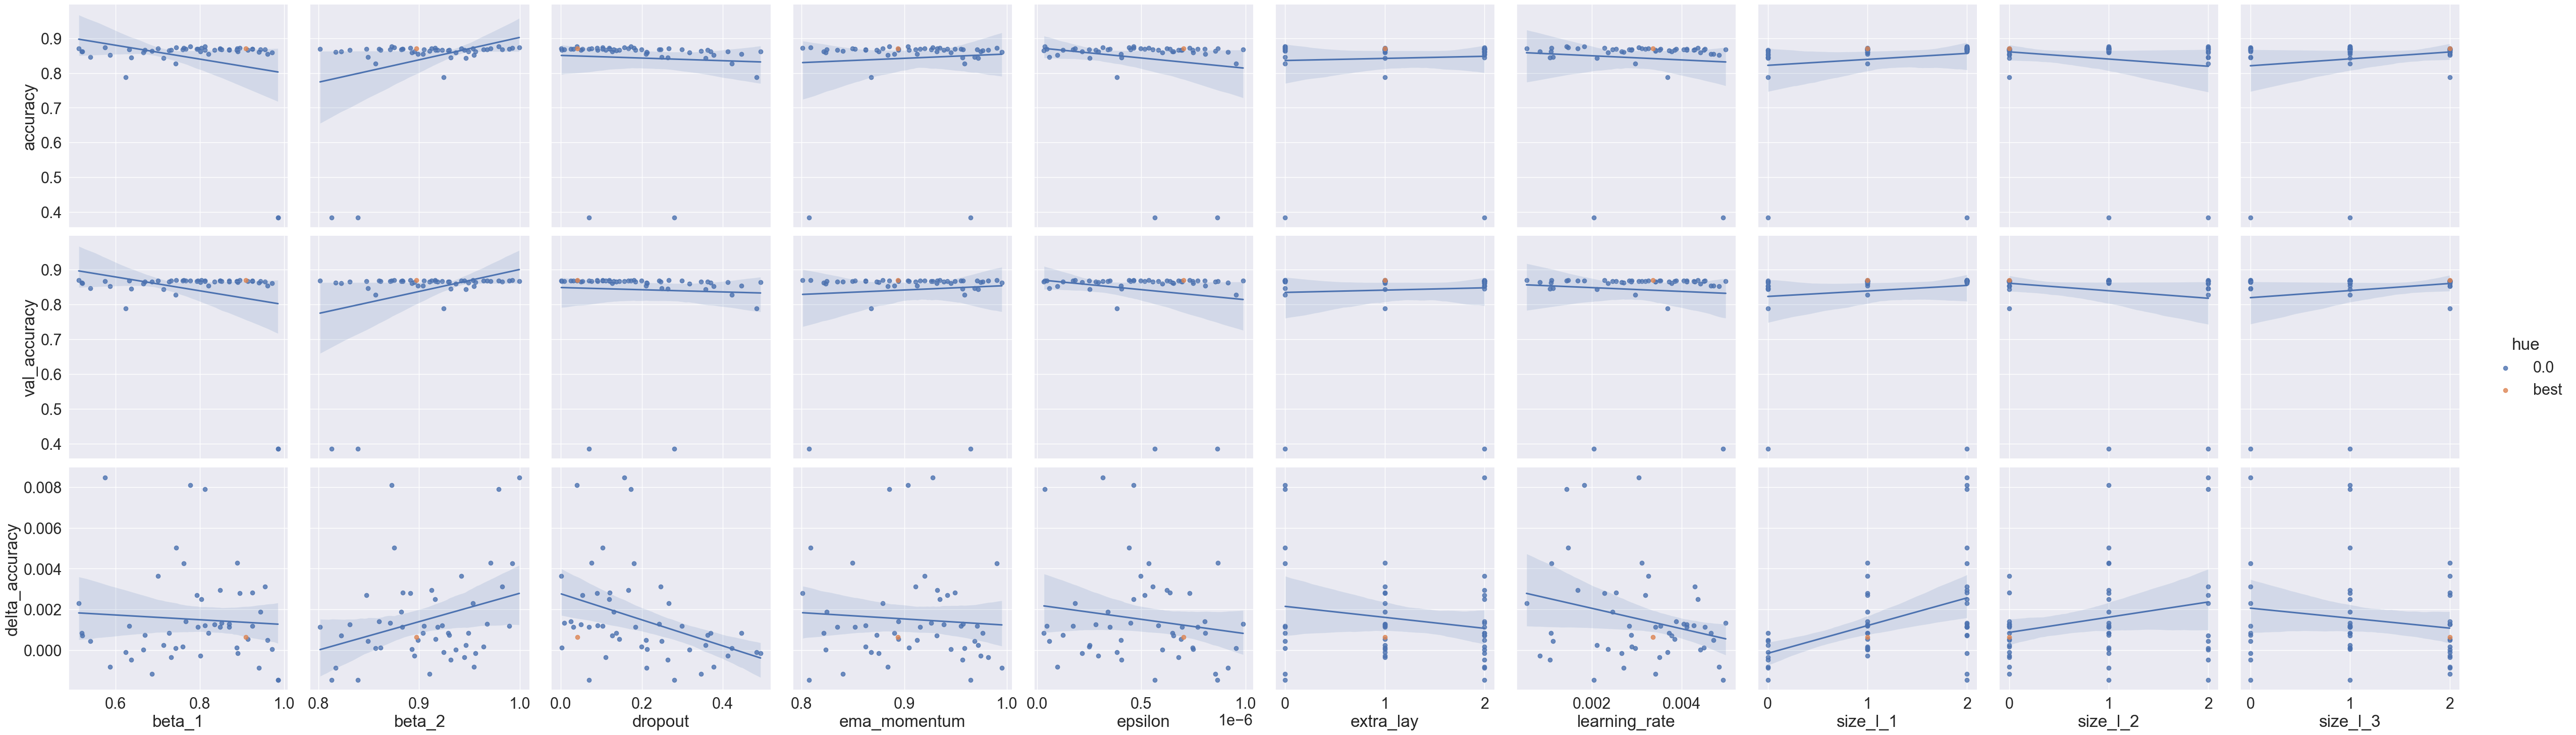

In [34]:
sns.set(font_scale = 2)
sns.pairplot(trial_res, x_vars=list(trial_res)[0:10], y_vars=list(trial_res)[10:13], kind='reg',  height=5, hue = 'hue')

In [10]:
best

{'beta_1': 0.6012115429597784,
 'beta_2': 0.8342016359854416,
 'dropout': 0.00956185724776542,
 'ema_momentum': 0.9425072341735632,
 'epsilon': 1.5092638258743137e-07,
 'learning_rate': 0.001234077866108187}

In [27]:
best = {'beta_1': 0.6012115429597784,
 'beta_2': 0.8342016359854416,
 'dropout': 0.00956185724776542,
 'ema_momentum': 0.9425072341735632,
 'epsilon': 1.5092638258743137e-07,
 'learning_rate': 0.001234077866108187}

In [15]:
best_hyperparams

{'beta_1': 0.5054678031646203,
 'beta_2': 0.9483840596795294,
 'dropout': 0.014560133610613937,
 'ema_momentum': 0.9279838218799413,
 'epsilon': 5.334404280334826e-07,
 'learning_rate': 0.0022920443441381737}

In [15]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
import tensorflow.keras as keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [85]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=25),
                Dropout(best['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])

optimizer = Adam(learning_rate=best['learning_rate'], beta_1=best['beta_1'], beta_2=best['beta_2'], epsilon=best['epsilon'], ema_momentum=best['ema_momentum'])
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=130,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0,
                callbacks=[tensorboard_callback]
            )

In [19]:
%tensorboard --logdir logs

In [ ]:
!tensorboard dev upload \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorboard
tensorboard.__version__

In [ ]:
NN_model

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=24),
                Dropout(best_hyperparams['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])

optimizer = Adam(learning_rate=best_hyperparams['learning_rate'], beta_1=best_hyperparams['beta_1'], beta_2=best_hyperparams['beta_2'], epsilon=best_hyperparams['epsilon'], ema_momentum=best_hyperparams['ema_momentum'])
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=65,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )

y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 1s 453us/step


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

(0.0, 2.0)

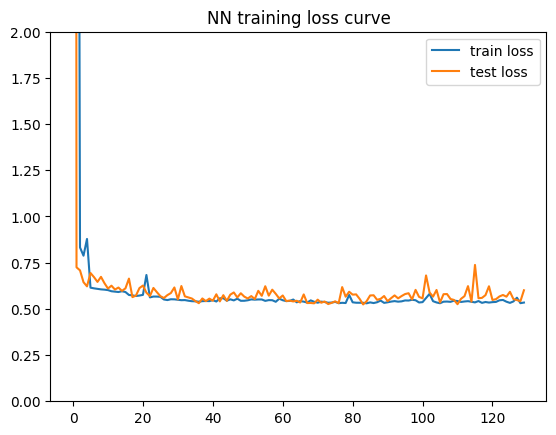

In [41]:
plt.plot(history.history['loss'],label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test loss')
plt.title('NN training loss curve')
plt.legend()
plt.ylim(0,2)

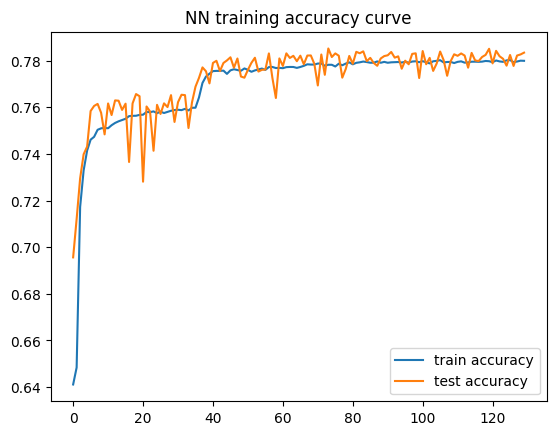

In [42]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.title('NN training accuracy curve')
plt.legend()

In [96]:
y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 7s 4ms/step


In [97]:
y_pred.shape

(52071, 3)

In [98]:
y_pred[0]

array([0.38784254, 0.38291648, 0.22924091], dtype=float32)

In [27]:
y_pred = np.argmax(y_pred,axis=1)

In [100]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
y_test = np.argmax(y_test,axis=1)

In [22]:
y_test

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

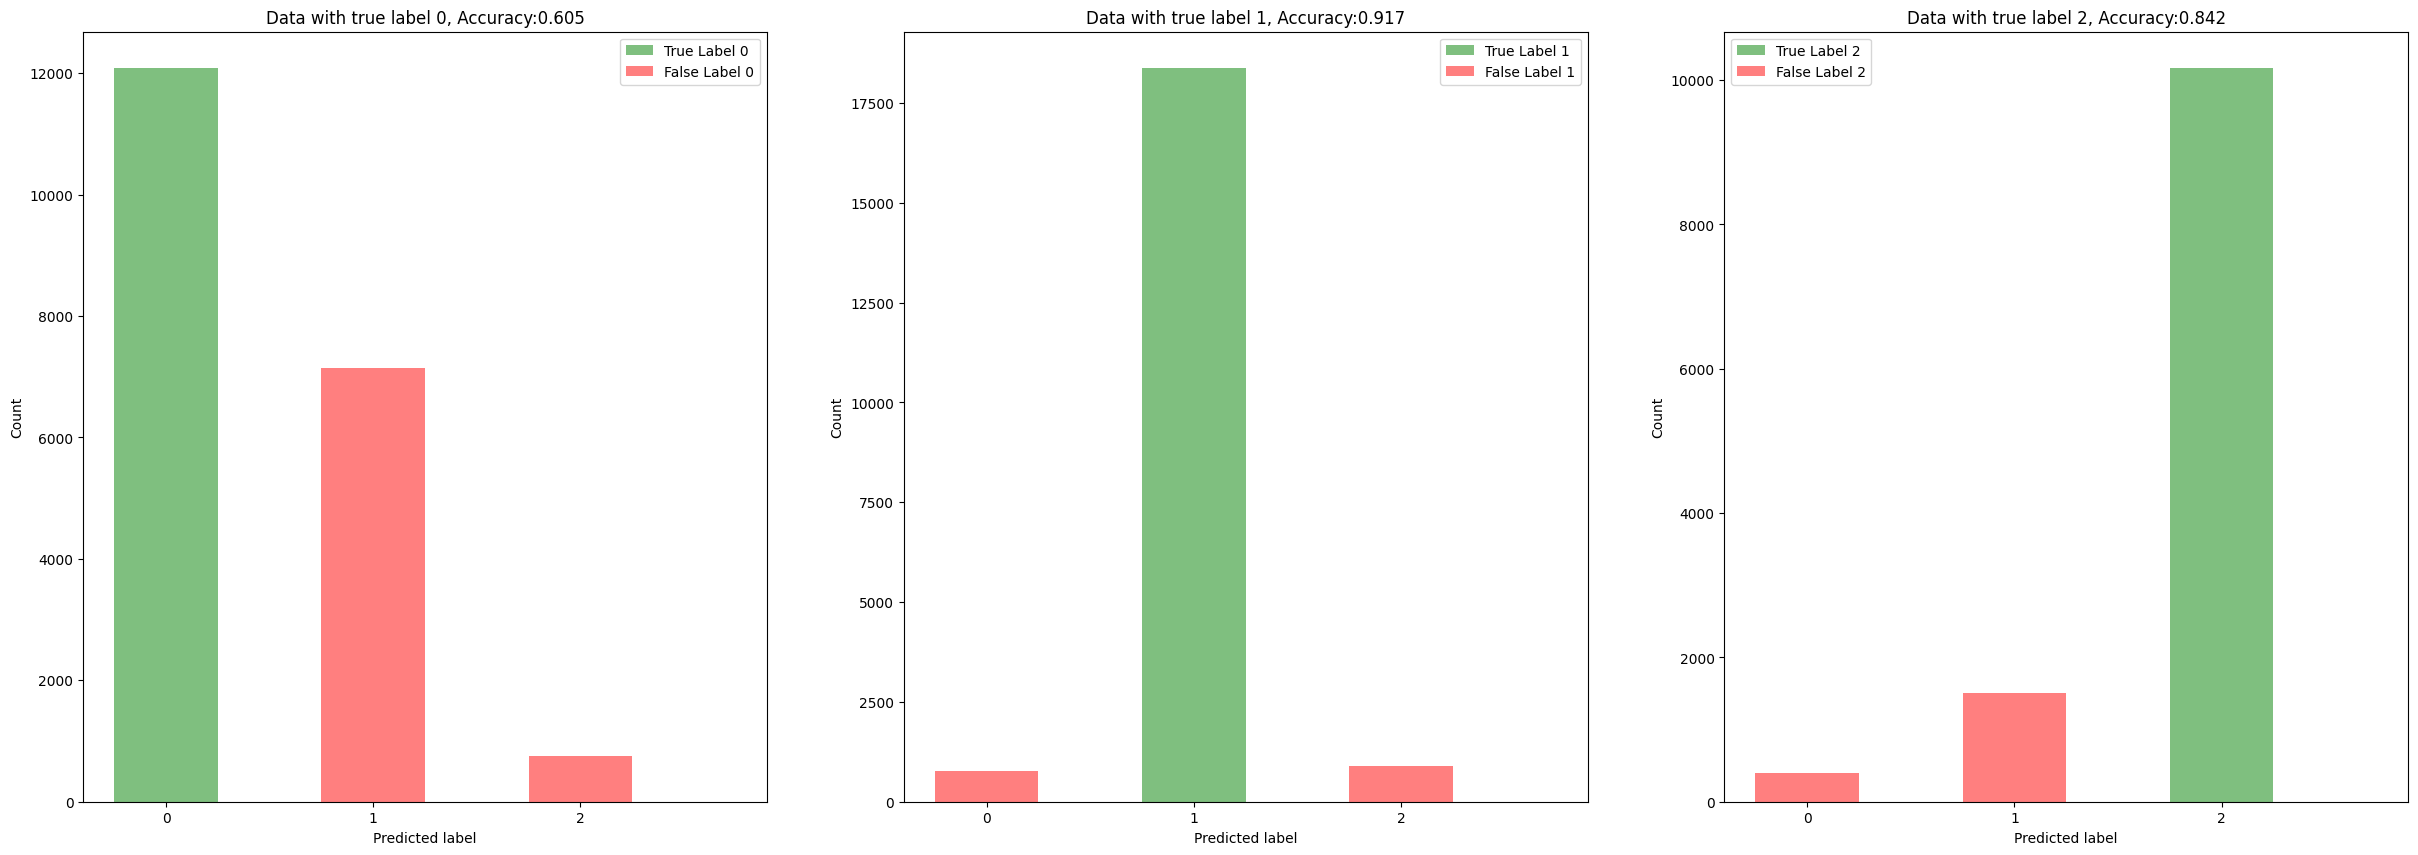

In [29]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_test[y_test==label]
    pred_label = y_pred[y_test==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))

In [86]:
y_pred = NN_model.predict(X_val)
y_pred_train = NN_model.predict(X_train)

9764/9764 [==============================] - 2s 222us/step


In [87]:
X_test.shape

(104141, 25)

In [88]:
y_pred[0]

array([0.00282543, 0.07427823, 0.9228963 ], dtype=float32)

In [89]:
for i in range(y_pred.shape[0]):
    n = np.argmax(y_pred[i])
    y_pred[i] = [0,0,0]
    y_pred[i][n] = 1


In [90]:
for i in range(y_pred_train.shape[0]):
    n = np.argmax(y_pred_train[i])
    y_pred_train[i] = [0,0,0]
    y_pred_train[i][n] = 1

In [91]:
y_pred = np.argmax(y_pred,axis=1)
y_pred_train = np.argmax(y_pred_train,axis=1)
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [77]:
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [56]:
y_train = np.argmax(y_train, axis =1)

In [51]:
y_val = np.argmax(y_val, axis =1)

In [53]:
y_pred_train.shape

(52071,)

In [59]:
y_train[y_train==0].shape

(160064,)

In [61]:
y_pred_train.shape

(52071,)

In [54]:
y_val.shape

(52071,)

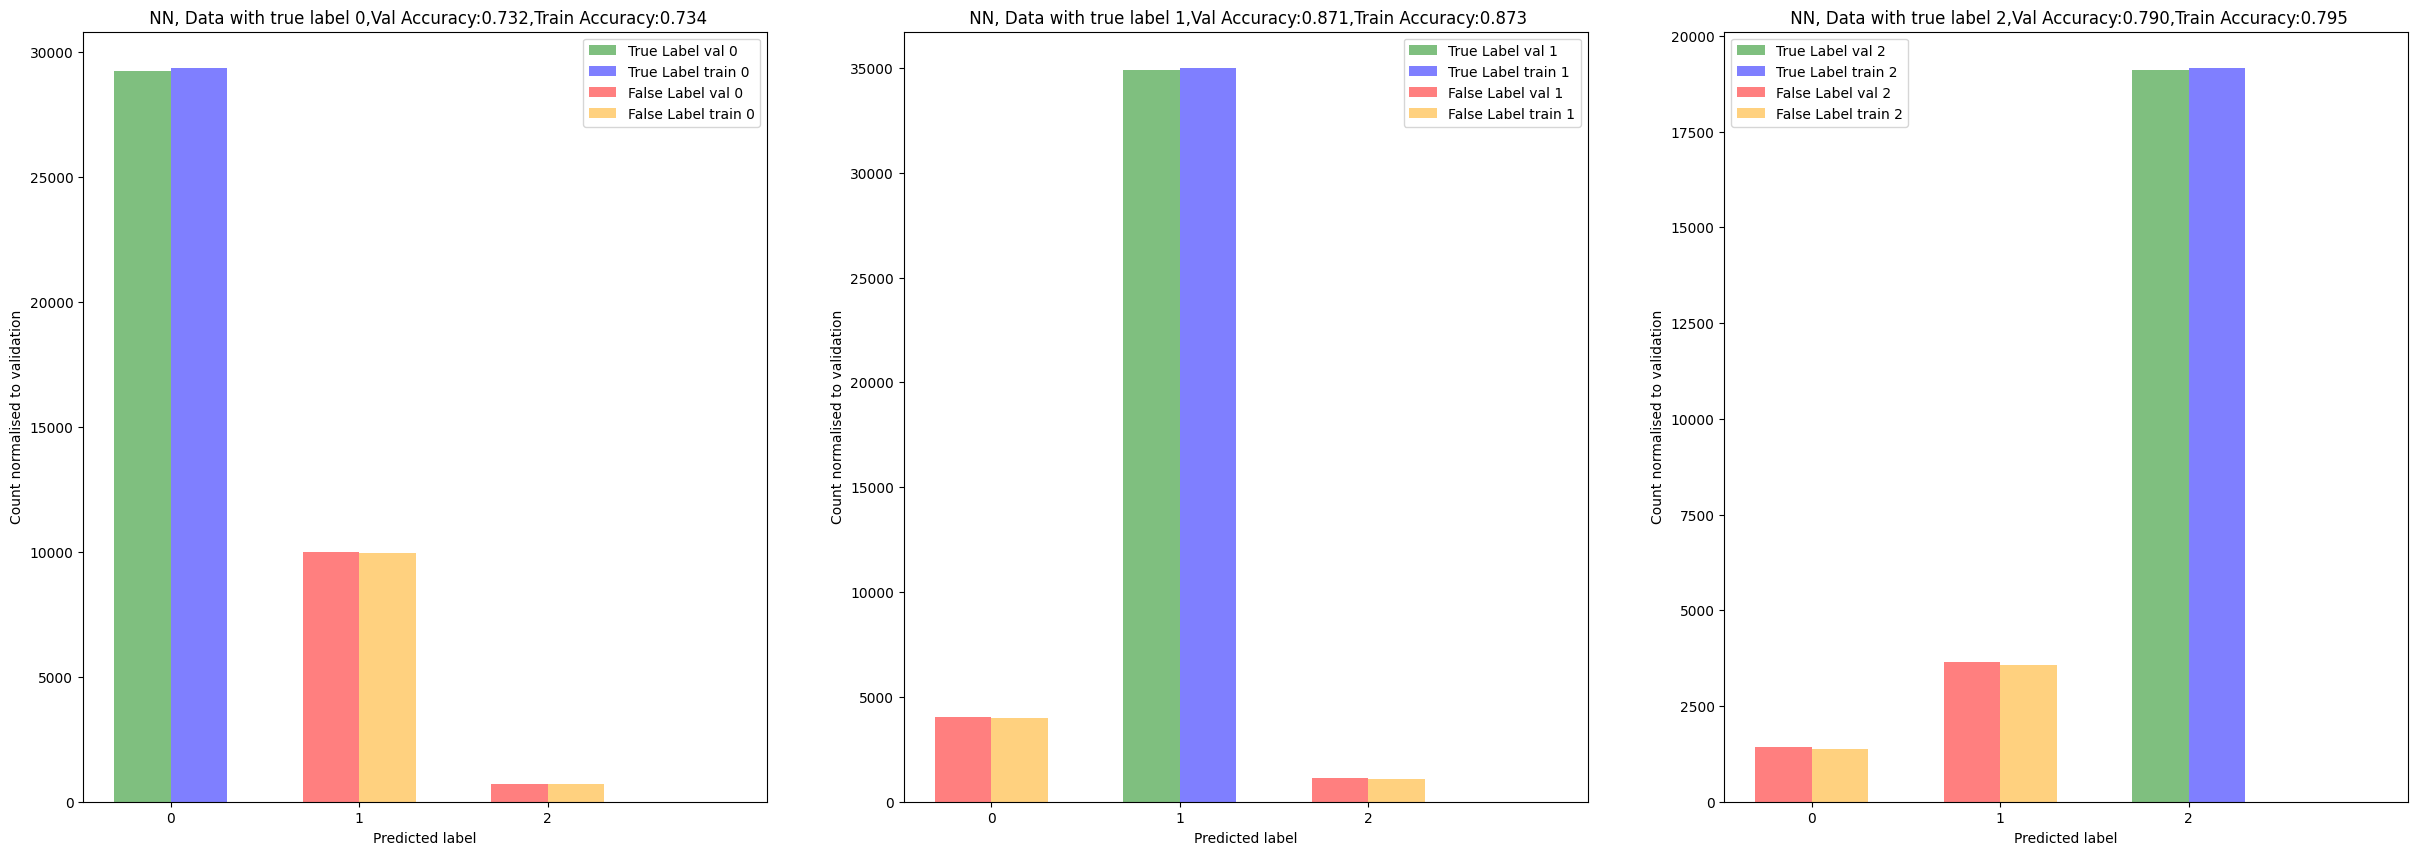

In [93]:
bins = [-0.3, 0.7, 1.7, 2.7] 
bins2 = [0, 1, 2, 3] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    
    test_label_t = y_train[y_train==label]
    pred_label_t = y_pred_train[y_train==label]
    true_label_t = pred_label_t[pred_label_t == test_label_t]
    false_label_t= pred_label_t[pred_label_t != test_label_t]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label val ' + str(label), align = 'mid', width = 0.3, color = 'green')
    ax[i].hist(true_label_t[0:int(round(len(true_label_t)/3,0))] , bins = bins2, histtype = 'barstacked', alpha=0.5, label='True Label train ' + str(label), align = 'mid', width = 0.3, color = 'blue') 
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label val ' + str(label), align = 'mid', width = 0.3, color = 'red')
    ax[i].hist(false_label_t[0:int(round(len(false_label_t)/3,0))], bins = bins2, histtype = 'barstacked', alpha=0.5, label='False Label train ' + str(label), align = 'mid', width = 0.3, color = 'orange')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f' NN, Data with true label {i},Val Accuracy:{accuracy_score(test_label, pred_label):.3f},Train Accuracy:{accuracy_score(test_label_t, pred_label_t):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count normalised to validation')
    ax[i].legend()
    ax[i].set_xticks(range(3))